# Modelagem dos dados

Neste notebook, foram realizadas as seguintes etapas:
* Feature selection
* Modelagem dos dados
* Fine tuning
* Avaliação do modelo

# 1. Bibliotecas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Seleção de Features
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV

# Avaliação de Modelos
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ks_2samp # KS2
from sklearn.model_selection import cross_val_score
#import scikitplot as skplt
#from scikitplot.metrics import plot_roc

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 2. Importação dos dados

In [3]:
X_train_transformed = pd.read_csv('outputs/X_train_transformed.csv')
y_train = pd.read_csv('outputs/y_train.csv')
X_test_transformed = pd.read_csv('outputs/X_test_transformed.csv')
y_test = pd.read_csv('outputs/y_test.csv')

In [4]:
# Verificando dados de treino

X_train_transformed.head()

,num__Age,num__Annual_Income,num__Monthly_Inhand_Salary,num__Num_Bank_Accounts,num__Num_Credit_Card,num__Interest_Rate,num__Num_of_Loan,num__Changed_Credit_Limit,num__Num_Credit_Inquiries,num__Outstanding_Debt,...,num__Credit_History_Age,num__Total_EMI_per_month,num__Amount_invested_monthly,num__Monthly_Balance,cat__Month,cat__Occupation,cat__Type_of_Loan,cat__Credit_Mix,cat__Payment_of_Min_Amount,cat__Payment_Behaviour
0,0.141176,0.246939,0.240899,0.015837,0.005910,0.006613,0.917431,0.336171,0.003470,0.104952,...,0.531017,0.000000,0.047113,1.0,0.897317,0.818440,0.149342,0.123962,0.610979,1.000000
1,0.482353,0.041447,0.081010,0.002262,0.004728,0.002436,0.917431,0.388032,0.001542,0.110783,...,0.910670,0.000000,0.010716,1.0,0.169958,0.580526,0.149342,0.000000,0.000000,1.000000
2,0.129412,0.066472,0.093704,0.018100,0.003546,0.006613,0.944954,0.275656,0.005012,0.402238,...,0.166253,0.000795,0.004060,1.0,1.000000,0.580526,0.489989,0.289470,0.610979,0.365552
3,0.305882,0.327573,0.319259,0.013575,0.005910,0.002436,0.935780,0.533364,0.001928,0.296368,...,0.915633,0.001405,0.030220,1.0,0.291172,0.575904,0.322103,0.289470,1.000000,0.444570
4,0.011765,0.074274,0.093475,0.009050,0.005910,0.005569,0.963303,0.497009,0.001542,0.102885,...,0.287841,0.001382,0.010276,1.0,0.897317,0.580526,0.520808,0.123962,1.000000,0.444570


# 3. Feature Selection

Etapas:

##### 3.1 Select K Best

* Testando o AUC com diferentes conjuntos e número de features
* 💡 Método que avalia individualmente cada feature em relação ao target, atribuindo uma pontuação e, em seguida, selecionando as k features com melhor pontuação
* O AUC foi a métrica utilizada no Select K Best, por ser uma métrica que independe do threshold para avaliar os dados

##### 3.2 KS2

* Verificando o KS2 por variável
* 💡 O KS2 mede a distância entre as distribuições de probabilidade acumulada (bons e maus pagadores)
* Quanto maior, melhor (variação de 0 a 100)

### 3.1 Select K Best

In [5]:
# Lista para armazenar os resultados do AUC

auc_array = []
k_array = list(range(1, 22))

In [6]:
 # Intervalo para k variando de 1 a 21

print(k_array)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [7]:
# Loop para verificar o número ideal de k features
for k in k_array:
    # Criar o seletor com as k características desejadas
    selector = SelectKBest(score_func=chi2, k=k)
    X_train_selected = selector.fit_transform(X_train_transformed, y_train)
    X_test_selected = selector.transform(X_test_transformed)
    
    # Treinando o modelo
    clf = RandomForestClassifier(class_weight='balanced',max_depth=4, n_estimators=150, random_state=42)
    clf.fit(X_train_selected, y_train)
    
     # Avaliando o modelo
    y_score = clf.predict_proba(X_test_selected)[:,1]
    auc = roc_auc_score(y_test, y_score)
    auc_array.append(auc)
    print(k, auc)

1 0.6859435891209325
2 0.8621029018941234
3 0.8795272826614862
4 0.8819375182127246
5 0.8797645883924236
6 0.8788267787761048
7 0.8700463938805245
8 0.8674791585721224
9 0.872712238950947
10 0.8731525922778047
11 0.8698866197183097
12 0.8677764995143273
13 0.8668179273919377
14 0.8741035757649345
15 0.8757793285575521
16 0.8799606969402622
17 0.882885514813016
18 0.8823289035939776
19 0.8792560830500245
20 0.8824286789703739
21 0.8776563683827101


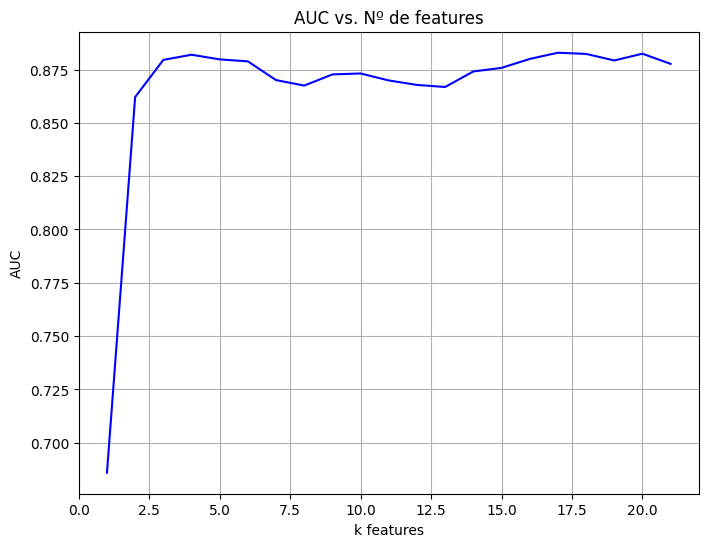

In [8]:
# Encontrando o número ideal de características
auc_max = auc_array[np.argmax(auc_array)]
k_max = k_array[np.argmax(auc_array)]

# Plotando o gráfico de AUC vs. k features
plt.figure(figsize=(8, 6))
plt.plot(k_array, auc_array, c='b')
plt.xlabel('k features')
plt.ylabel('AUC')
plt.title('AUC vs. Nº de features')
plt.grid()
plt.show()

Foi percebido que o AUC obteve poucas variações. Por esse motivo, parece razoável manter a quantidade total de features, sem exclusões.

### 3.2 KS2

In [9]:
def ks_test(df, col, target):
    group_0 = df.loc[df[target] == 0, col].dropna()
    group_1 = df.loc[df[target] == 1, col].dropna()
    ks_stat, _ = ks_2samp(group_0, group_1)
    return ks_stat

In [10]:
df_train_transformed = pd.concat([X_train_transformed,y_train], axis=1)

In [11]:
cols = X_train_transformed.columns

In [12]:
ks_dic = {}

for col in cols:
    ks = ks_test(df_train_transformed, col, 'target')
    ks_dic[col] = ks

In [13]:
# Definindo o KS das variáveis

df_ks = pd.DataFrame([ks_dic]).T
df_ks_final = df_ks.sort_values(by=0, ascending=False).reset_index()
df_ks_final.columns = ['Variable', 'KS_Value']
df_ks_final = df_ks_final.set_index('Variable')

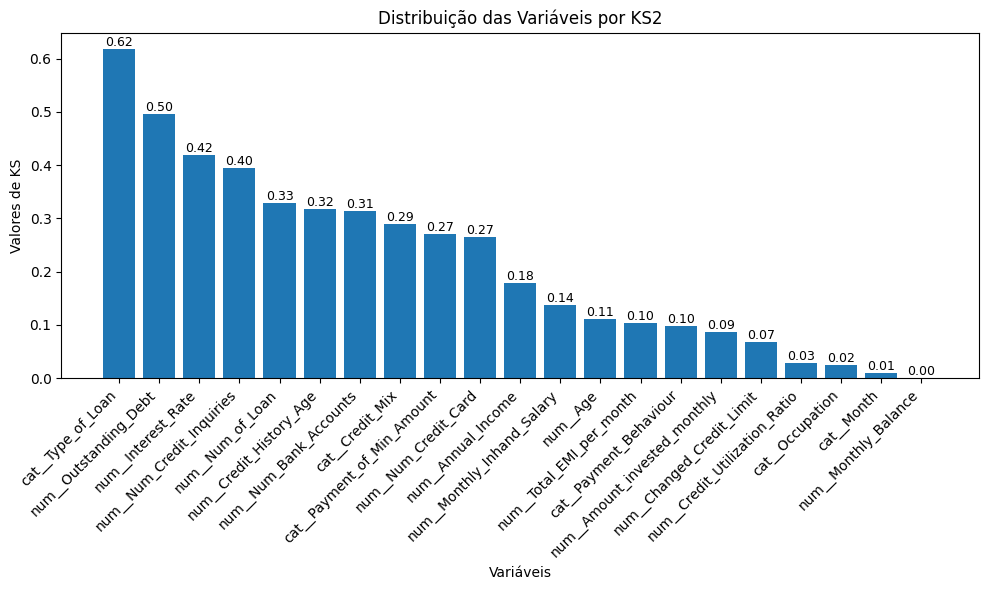

In [14]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_ks_final.index, df_ks_final['KS_Value'])
plt.xlabel("Variáveis")
plt.ylabel("Valores de KS")
plt.title("Distribuição das Variáveis por KS2")
plt.xticks(rotation=45, ha='right')

# Adicionando os valores de KS nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Posição horizontal (meio da barra)
        height,                             # Posição vertical (no topo da barra)
        f'{height:.2f}',                    # Texto com duas casas decimais
        ha='center', va='bottom', fontsize=9  # Alinhamento e tamanho da fonte
    )

plt.tight_layout()
plt.show()

In [15]:
df_ks_final

,KS_Value
Variable,
cat__Type_of_Loan,0.617409
num__Outstanding_Debt,0.496133
num__Interest_Rate,0.419518
num__Num_Credit_Inquiries,0.395031
num__Num_of_Loan,0.328698
num__Credit_History_Age,0.318098
num__Num_Bank_Accounts,0.314150
cat__Credit_Mix,0.288460
cat__Payment_of_Min_Amount,0.270392


⚠️ A variável `cat__Type_of_Loan` apresentou um valor de KS2 elevado, indicando que pode ser relevante para distinguir bons e maus pagadores. No entanto, é importante monitorá-la com atenção, pois a especificidade de suas combinações de tipos de empréstimos pode tornar o modelo excessivamente ajustado aos dados de treino, aumentando o risco de overfitting.

Após a avaliação acima, percebeu-se que o KS2 foi maior em variáveis que apresentaram uma maior diferença de taxa de maus entre o maior e menor grupo analisado na EDA. Ex: `Outstanding_Debt`, `Interest_Rate` e `Num_Credit_Inquiries`. As variáveis `cat__Month` e `num__Monthly_Balance` apresentaram um KS2 muito baixo, favorecendo suas exclusões do modelo.

In [16]:
# Drop das variáveis com menor KS2
drop_cols = ['cat__Month','num__Monthly_Balance']
X_train_transformed = X_train_transformed.drop(drop_cols,axis=1)
X_test_transformed = X_test_transformed.drop(drop_cols,axis=1)

# 4. Modelagem

* Dummy Classifier (para comparativos)
* Logistic Regression
* Random Forest Classifier
* Decision Tree Classifier
* XGB Classifier
  
Para uma avaliação mais robusta e melhor chance de generalização, foi utilizada a validação cruzada para treinar os dados de treino, pois fornece uma visão mais robusta e menos dependente da divisão específica dos dados. No entanto, o modelo foi avaliado com o conjunto de teste para a obtenção do KS2.

### 4.1 Dummy Classifier

Modelagem + cross validation (AUC)


In [17]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
cvs = cross_val_score(estimator=clf, X=X_train_transformed, y=y_train, scoring='roc_auc', cv=3, verbose=1)
print(f"ROC-AUC: {cvs.mean():.2f}")

ROC-AUC: 0.50


In [18]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  20000 non-null  int64
dtypes: int64(1)
memory usage: 156.4 KB


Modelagem + avaliação no teste (KS2)

In [19]:
# Ajustando o modelo DummyClassifier com todo o conjunto de treino
clf.fit(X_train_transformed, y_train)

# Calculando as probabilidades preditas
dummy_y_pred_probs = clf.predict_proba(X_test_transformed)[:, 1]

# Calculando o KS2
ks_stat_dummy, _ = ks_2samp(dummy_y_pred_probs[(y_test == 1).to_numpy().ravel()], 
                            dummy_y_pred_probs[(y_test == 0).to_numpy().ravel()])
print(f"KS2 (DummyClassifier): {ks_stat_dummy:.3f}")

KS2 (DummyClassifier): 0.000


### 4.2 Logistic Regression

Modelagem + cross validation (AUC)

In [20]:
clf = LogisticRegression(class_weight='balanced', max_iter=2000,random_state=42)
cvs = cross_val_score(estimator=clf, X=X_train_transformed, y=y_train, scoring='roc_auc', cv=3, verbose=1)
print(f"ROC-AUC: {cvs.mean():.3f}")

ROC-AUC: 0.854


Modelagem + avaliação no teste (KS2)

In [21]:
# Ajustando o modelo com todo o conjunto de treino
clf.fit(X_train_transformed, y_train)

# Calculando as probabilidades preditas
logreg_y_pred_probs = clf.predict_proba(X_test_transformed)[:, 1]

# Calculando o KS2
ks_stat_logreg, _ = ks_2samp(logreg_y_pred_probs[(y_test == 1).to_numpy().ravel()],
                             logreg_y_pred_probs[(y_test == 0).to_numpy().ravel()])
print(f"KS2 (Logistic Regression): {ks_stat_logreg:.3f}")

KS2 (Logistic Regression): 0.592


### 4.3 Random Forest Classifier

Modelagem + cross validation (AUC)

In [22]:
clf = RandomForestClassifier(class_weight='balanced',max_depth=4, n_estimators=150, random_state=42)
cvs = cross_val_score(estimator=clf, X=X_train_transformed, y=y_train, scoring='roc_auc', cv=3, verbose=1)
print(f"ROC-AUC: {cvs.mean():.3f}")

ROC-AUC: 0.895


Modelagem + avaliação no teste (KS2)

In [23]:
# Ajustando o modelo com todo o conjunto de treino
clf.fit(X_train_transformed, y_train)

# Calculando as probabilidades preditas
rfc_y_pred_probs = clf.predict_proba(X_test_transformed)[:, 1]

# Calculando o KS2
ks_stat_rfc, _ = ks_2samp(rfc_y_pred_probs[(y_test == 1).to_numpy().ravel()],
                          rfc_y_pred_probs[(y_test == 0).to_numpy().ravel()])
print(f"KS2 (Random Forest Classifier): {ks_stat_rfc:.3f}")

KS2 (Random Forest Classifier): 0.674


### 4.4 Decision Tree Classifier

Modelagem + cross validation (AUC)

In [24]:
clf = DecisionTreeClassifier(max_depth=4)
cvs = cross_val_score(estimator=clf, X=X_train_transformed, y=y_train, scoring='roc_auc', cv=3, verbose=1)
print(f"ROC-AUC: {cvs.mean():.3f}")

ROC-AUC: 0.901


Modelagem + avaliação no teste (KS2)

In [25]:
# Ajustando o modelo com todo o conjunto de treino
clf.fit(X_train_transformed, y_train)

# Calculando as probabilidades preditas
dtc_y_pred_probs = clf.predict_proba(X_test_transformed)[:, 1]

# Calculando o KS2
ks_stat_dtc, _ = ks_2samp(dtc_y_pred_probs[(y_test == 1).to_numpy().ravel()],
                          dtc_y_pred_probs[(y_test == 0).to_numpy().ravel()])
print(f"KS2 (Decision Tree Classifier): {ks_stat_dtc:.3f}")

KS2 (Decision Tree Classifier): 0.648


### 4.5 XGBClassifier

Modelagem + cross validation (AUC)

In [26]:
clf = XGBClassifier(n_estimators=50, max_depth=2, random_state=42)
cvs = cross_val_score(estimator=clf, X=X_train_transformed, y=y_train, scoring='roc_auc', cv=3, verbose=1)
print(f"ROC-AUC: {cvs.mean():.3f}")

ROC-AUC: 0.922


Modelagem + avaliação no teste (KS2)

In [27]:
# Ajustando o modelo com todo o conjunto de treino
clf.fit(X_train_transformed, y_train)

# Calculando as probabilidades preditas
xgbc_y_pred_probs = clf.predict_proba(X_test_transformed)[:, 1]

# Calculando o KS2
ks_stat_xgbc, _ = ks_2samp(xgbc_y_pred_probs[(y_test == 1).to_numpy().ravel()],
                           xgbc_y_pred_probs[(y_test == 0).to_numpy().ravel()])
print(f"KS2 (XGBClassifier): {ks_stat_xgbc:.3f}")

KS2 (XGBClassifier): 0.666


O XGBClassifier foi o modelo que teve a melhor pontuação de AUC e KS2, por esse motivo, foi o modelo escolhido para o projeto.

# 5. Otimização de hiperparâmetros

* Modelo: XGBClassifier  
* Parâmetros: n_estimators, max_depth, learning_rate  
* Otimização: RandomizedSearchCV

In [28]:
# %%time
# xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)

# param = {'n_estimators' : [100, 200, 500, 1000, 1500],
#          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
#          'learning_rate':[0.0001, 0.001, 0.01, 0.05, 0.1, 1]
#         }

# xgb_otimizado = RandomizedSearchCV(estimator=xgb_clf, param_distributions= param, n_iter=100,
#                                    scoring='roc_auc', cv=5, random_state=42, verbose=1, refit=True)

# xgb_otimizado.fit(X_train_transformed, y_train)

In [29]:
# xgb_otimizado.best_estimator_

In [30]:
# xgb_otimizado.best_score_

In [31]:
# xgb_final = xgb_otimizado.best_estimator_

In [32]:
import pickle

# # Salvando o modelo final na pasta 'outputs'

# with open('outputs/xgb_final.pkl', 'wb') as f:
#     pickle.dump(xgb_final, f)

In [33]:
# Carregando o modelo salvo da pasta 'outputs'

with open('outputs/xgb_final.pkl', 'rb') as f:
    xgb_final_carregado = pickle.load(f)

# 6. Avaliação final

### 6.1 SHAP

Nesse contexto de crédito, a análise do shap permite dizer que quanto mais direcionado para direita, pior o score (maior probabilidade de inadimplentes).

In [34]:
import shap

In [35]:
# # Criando o explicador baseado no modelo

# explainer = shap.Explainer(xgb_final, X_train_transformed)
# explainer = shap.TreeExplainer(xgb_final_carregado)

In [36]:
# # Calculando os valores SHAP para o conjunto de teste

# shap_values = explainer(X_test_transformed)
# shap_values = explainer(X_train_transformed)

In [37]:
# # Salvando

# with open('outputs/shap_values.pkl', 'wb') as f:
#   pickle.dump(shap_values, f)

In [38]:
# Carregando os valores shap salvos

with open('outputs/shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

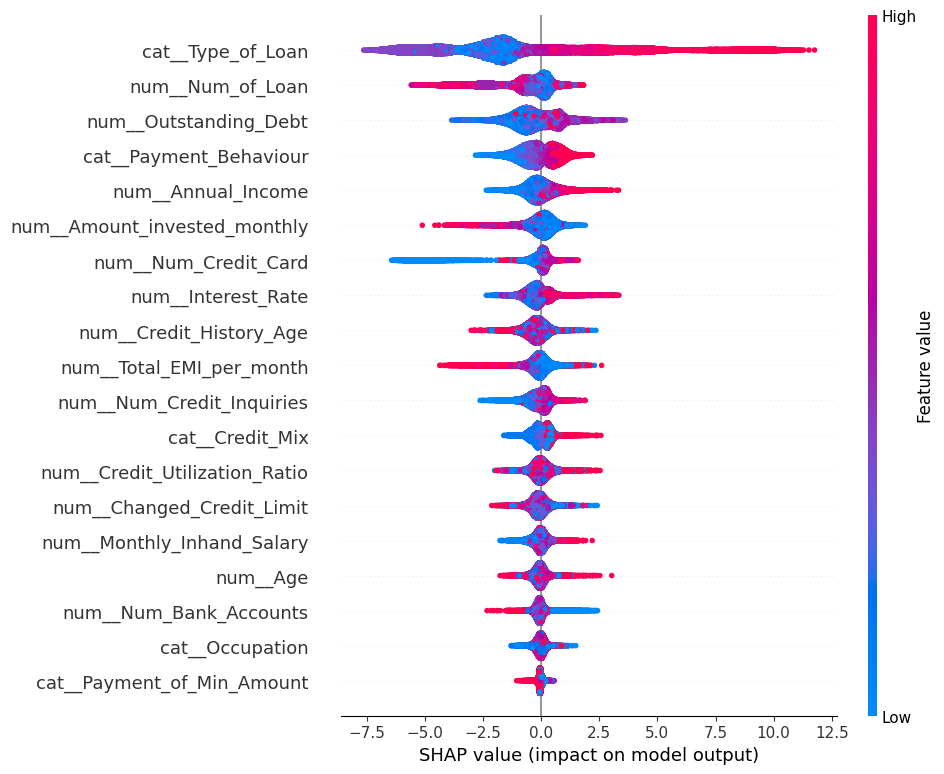

In [39]:
shap.plots.beeswarm(shap_values, max_display=21)

`Feature value`: menor e maior valor da feature. Low (azul): valor mínimo. High (Rosa): valor máximo  
`SHAP value`: quanto mais à direita, maior a probabilidade de ser mau pagador

**Alguns pontos que chamaram atenção**:  
* As variáveis categóricas não seguem uma lógica tão clara de maior ou menor associadas ao score, por esse motivo, não foram conclusivas (ex: `Type_of_Loan`)
  
* Comparando com a EDA, algumas análises do SHAP não ocorreram conforme o esperado como nas variáveis abaixo:

  
  * `Annual_Income` (renda anual do cliente):

    na EDA, a taxa de maus foi maior em clientes com renda menor, diferente do observado aqui no SHAP, com uma probabilidade de maus maior em rendas maiores
  * `Total_EMI_per_month`(valor da parcela paga todos os meses para um empréstimo ou financiamento):
  
    na EDA, a taxa de maus foi maior em clientes com maiores valores de parcela, também diferente do esperado aqui no SHAP
  
  * `Credit_Utilization_Ratio`(proporção da utilização do crédito disponível):

    na EDA, pessoas com mais crédito disponível obtiveram a menor taxa de inadimplentes, também um pouco diferente do esperado aqui no SHAP
  
  * `Changed_Credit_Limit` (alteração no limite de crédito):

    na EDA, a taxa de maus pagadores foi um pouco maior em indivíduos com mais alterações de limite de crédito, também diferente do observado na probabilidade apresentada no SHAP
    
  * `Monthly_Inhand_Salary`(salário mensal):

    na EDA, pessoas com a faixa salarial menor foram categorizadas com a maior taxa de maus pagadores, diferente do apresentado no SHAP
    
  * `Age` (idade):
  
    na EDA, quanto menor a idade, maior a taxa de maus pagadores, diferente do apresentado no SHAP (que se demonstra bastante dividido). Nesse caso, o tratamento de outliers pode ter alterado essa análise
    
  * `Num_Bank_Accounts` (número de contas bancárias que o cliente possui):

    na EDA, a taxa de maus pagadores é foi maior em indivíduos com maior quantidade de contas bancárias, o SHAP parece estar mantendo uma posição contrária.

### 6.2 Feature importance

In [40]:
feature_importance = []

for i in zip(X_train_transformed.columns, xgb_final_carregado.feature_importances_):
    feature_importance.append(i)

In [41]:
df_feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'importance']).sort_values('importance', ascending=False)

<Axes: xlabel='importance', ylabel='feature'>

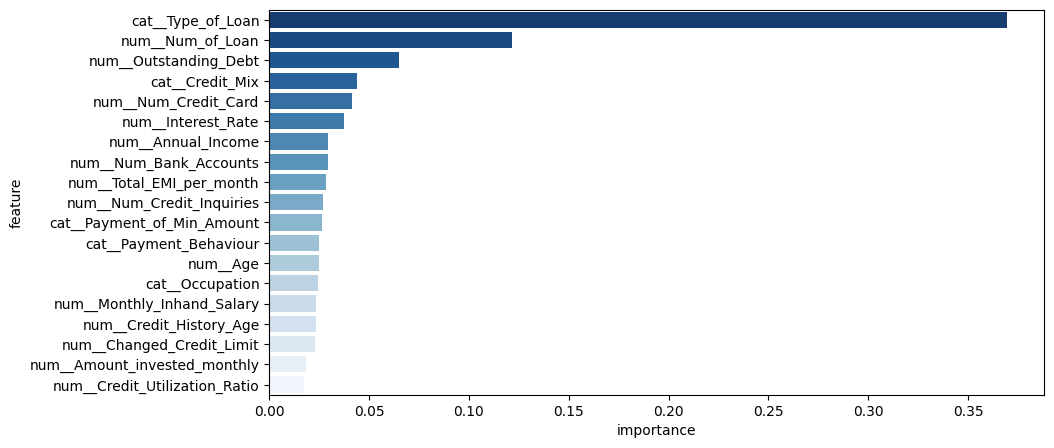

In [42]:
plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="feature", data=df_feature_importance, palette="Blues_r")

* A importância acima é chamada Tree Feature Importance (TFI): quantas vezes a variável aparece nas árvores do modelo;
* Podemos calcular a importância também a partir do SHAP;
* Percebeu-se que as três features de maior importância encontadas foram: `cat_Type_of_Loan`, `num_Num_of_Loan` e `num_Outstanding_Debt`.

### 6.3 Predict dos dados de teste

In [43]:
y_pred = xgb_final_carregado.predict(X_test_transformed)
y_score = xgb_final_carregado.predict_proba(X_test_transformed)[:,1]

# print(classification_report(y_test, y_pred))
print(f'AUC: {roc_auc_score(y_test, y_score):.3f}')

AUC: 0.939


### 6.4 Curva ROC

`TPR (True Positive Rate`:
recall ou exemplos positivos corretamente identificados. Ou seja, no problema do projeto, seriam os maus que foram classificados como maus;  
`FPR (False Positive Rate)`:
exemplos negativos incorretamente classificados como positivos. Ou seja, seriam os bons pagadores classificados como maus.

A linha diagonal representa a escolha aleatória, por esse motivo, representaria que o modelo não está conseguindo diferenciar as classes corretamente. Como a curva ROC não se aproxima tanto da linha tracejada, significa que o modelo apresenta um desempenho bem melhor que o de um modelo aleatório

Um modelo ideal teria uma curva ROC que subisse rapidamente para o canto superior esquerdo (TPR = 1 e FPR = 0), com o objetivo de ter um alto TPR e baixo FPR.Na imagem abaixo, é possível perceber que o resultado foi satisfatório.

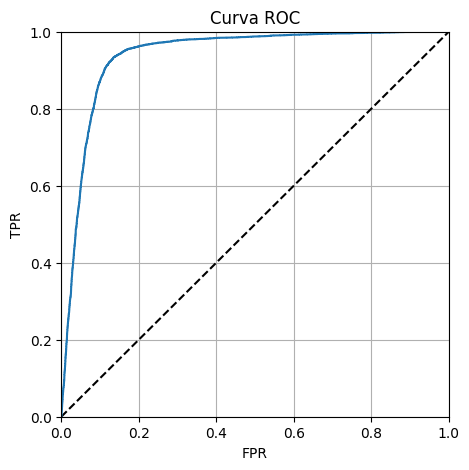

In [44]:
plt.figure(figsize=(5,5))
fpr, tpr, thr = roc_curve(y_test, y_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Curva ROC')
plt.show()

### 6.5 Precision e Recall

Este gráfico representa a relação entre Precisão (em vermelho) e Recall (em azul) à medida que o threshold (limiar) de decisão do classificador é alterado.

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)

Text(0.5, 1.0, 'Precisão e Recall')

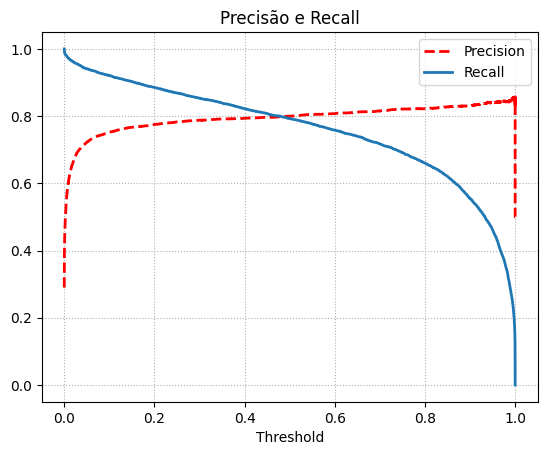

In [46]:
plt.plot(thresholds, precisions[:-1], lw=2, c='r', ls='--',label='Precision')
plt.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid(ls=":")
plt.title("Precisão e Recall")

**Trade-off**: Conforme o limiar aumenta o recall cai (menos exemplos positivos são identificados corretamente) e a precisão aumenta inicialmente (até certo ponto), pois o modelo comete menos erros ao ser mais seletivo.

**Precisão**: No contexto de crédito, a precisão indica quantos dos clientes classificados como inadimplentes (riscos de crédito) realmente serão inadimplentes. Se a precisão for baixa, significa que a instituição está recusando crédito a muitos clientes que pagariam (falsos positivos). Isso pode resultar em perda de receita por rejeitar clientes bons.

**Recall**: Já o Recall representa a capacidade do modelo de identificar corretamente todos os inadimplentes possíveis. Se o recall for baixo, muitos clientes que deveriam ser identificados como inadimplentes receberão crédito (falsos negativos), resultando em aumento de inadimplência e maiores prejuízos.

O ideal seria um equilíbrio. Isso porque, embora a inadimplência seja prejudicial, rejeitar muitos clientes bons também pode impactar os lucros. No entanto, depende bastante também da avaliação de negócio.

### 6.6 Taxa de maus pagadores por decil

In [47]:
test_scores = xgb_final_carregado.predict_proba(X_test_transformed)[:,1]

In [48]:
df_test_scores = pd.DataFrame(test_scores, columns=['score']) # agrupando as probabilidades
df_test_scores['decil'] = pd.qcut(test_scores, q=10, labels=[1,2,3,4,5,6,7,8,9,10]) # separando-as em decis
df_test_scores['target'] = y_test.reset_index(drop=True)

Para cada decil, foi calculada a média do target por decil.  
Decil 1: ↑ taxa de maus  
Decil 10: ↓ taxa de maus  

In [49]:
# Taxa de maus por decil
maus_por_decil = pd.DataFrame(df_test_scores.groupby('decil')['target'].mean()).reset_index()
maus_por_decil

,decil,target
0,1,0.0040
1,2,0.0085
2,3,0.0130
3,4,0.0180
4,5,0.0200
5,6,0.0665
6,7,0.3885
7,8,0.7215
8,9,0.8140
9,10,0.8460


<Axes: xlabel='decil', ylabel='target'>

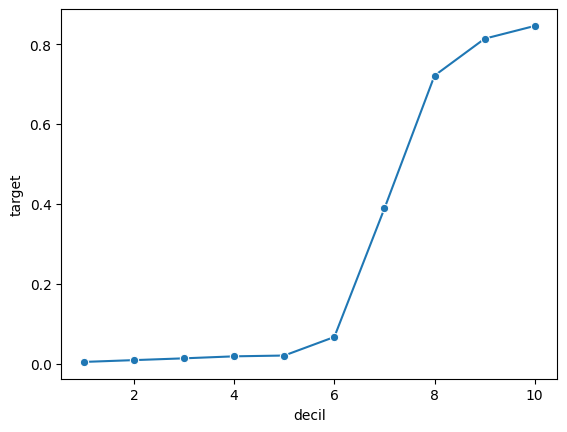

In [50]:
sns.lineplot(maus_por_decil, x='decil', y='target',marker='o')

Foi medida a taxa de maus em cada uma das partes. Ou seja, em cada decil, foi calculada a média do target por decil. Espera-se que nos maiores decis estejam os maus pagadores (taxa de maus maior), enquanto nos menores decis estejam os bons pagadores (taxa de maus menor).

### 6.7 Matriz de confusão

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     14200
           1       0.80      0.79      0.80      5800

    accuracy                           0.88     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.88      0.88      0.88     20000



<Figure size 800x600 with 0 Axes>

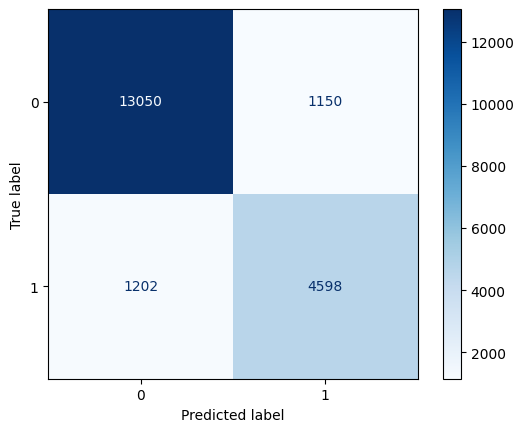

In [52]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize= (8,6))
ConfusionMatrixDisplay(cm).plot(cmap='Blues') 
plt.show()

De acordo com o resultado acima, percebeu-se que:

* **[0, 0]: Verdadeiros negativos (13050)**  
O modelo previu corretamente que esses clientes não são inadimplentes.  
* **[0, 1]: Falsos positivos (1150)**  
O modelo classificou erroneamente esses clientes como inadimplentes, mas na verdade não eram.  
* **[1, 0]: Falsos negativos (1202)**  
O modelo previu que esses clientes não eram inadimplentes, mas na verdade eram.  
* **[1, 1]: Verdadeiros positivos (4598)**  
O modelo previu corretamente que esses clientes são inadimplentes.

In [53]:
# Verificando o threshold

y_pred_analysis = pd.DataFrame(y_pred, columns=['pred'])
predict_proba_analysis = pd.DataFrame(np.round(test_scores,5),columns=['proba'])
y_pred_prob_analysis = pd.concat([predict_proba_analysis,y_pred_analysis],axis=1)
y_pred_prob_analysis

,proba,pred
0,0.58211,1
1,0.00000,0
2,0.80341,1
3,0.00000,0
4,0.82859,1
...,...,...
19995,0.00011,0
19996,0.00562,0
19997,0.00262,0
19998,0.95076,1


* O resultado apresentado foi obtido utilizando o threshold padrão de 0.5. Isso significa que clientes com um score superior a 0.5 são classificados como inadimplentes (mau pagadores), enquanto aqueles com score inferior a 0.5 são classificados como bons pagadores.
No entanto, o valor do threshold deve ser definido com base nas necessidades estratégicas da instituição;

* A escolha do threshold pode impactar diretamente as métricas de desempenho, como recall e precisão, e, portanto, deve ser ajustada conforme os objetivos de negócio da empresa. Dependendo da prioridade, pode-se optar por um threshold que favoreça a minimização de falsos negativos (aumentando o recall) ou a redução de falsos positivos (aumentando a precisão);

* A respeito dos falsos negativos: É mais importante evitá-los (minimizar risco financeiro) ou reduzir os falsos positivos (evitar perder clientes bons)? Isso vai ser comentado na análise de negócio.

### 6.8 KS2

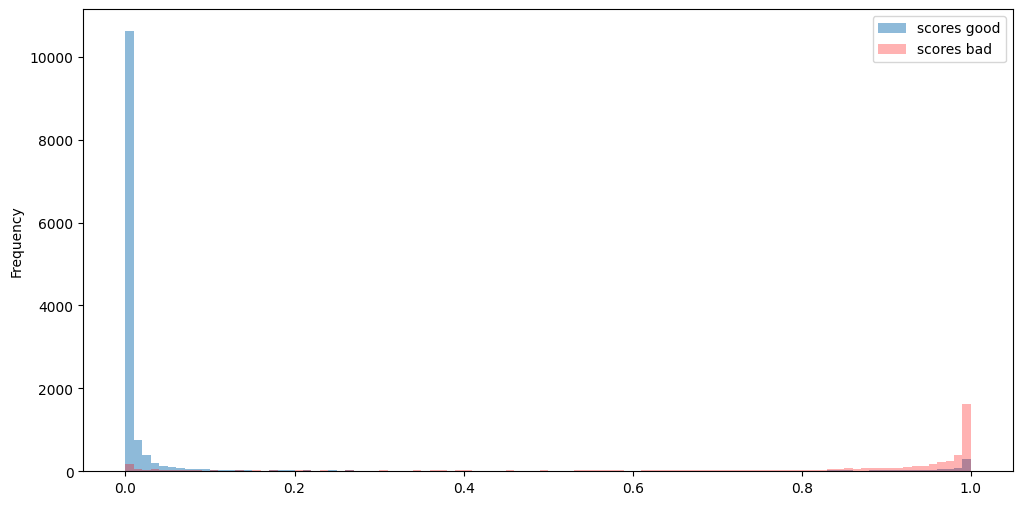

In [54]:
plt.figure(figsize=(12, 6)) 
df_test_scores[df_test_scores['target'] == 0]['score'].plot(kind='hist', bins=100, label='scores good', alpha= 0.5)
df_test_scores[df_test_scores['target'] == 1]['score'].plot(kind='hist', bins=100, label='scores bad', color='red', alpha=0.3)
plt.legend()
plt.show()

In [55]:
ks_2samp(df_test_scores[df_test_scores['target'] == 1]['score'],
         df_test_scores[df_test_scores['target'] == 0]['score']
        )

KstestResult(statistic=np.float64(0.7985502671199611), pvalue=np.float64(0.0), statistic_location=np.float32(0.06914478), statistic_sign=np.int8(-1))

O KS mede a diferença das distribuições, no caso, de bons e maus pagadores. Quanto maior, melhor, pois espera-se que bons pagadores tenham score alto e maus pagadores tenham score baixo. No caso acima, o valor foi de 0.22, indicando um score muito bom.

# 7. Conclusão da modelagem

* As variáveis `cat__Month` e `num__Monthly_Balance` apresentaram um KS2 muito baixo, por esse motivo, foram excluídas do modelo;
* A avaliação geral dos modelos priorizou o `XGBClassifier`, que apresentou melhor pontuação de AUC na validação cruzada utilizada para treinar os dados de treino. Também apresentou melhor performance de KS2;
* A avaliação do SHAP apresentou resultados diferentes do esperado. Talvez seja o caso de testar novas transformações no pré-processamento ou tratamento dos dados. Mais avaliações precisariam ser realizadas para melhores conclusões;
* O AUC no predict final com os dados de teste foi de 0.939, valor bastante favorável ao modelo;
* A curva ROC, precision e recall apresentaram-se de acordo com o esperado para o resultado acima, assim como a taxa de maus por decil;
* A matriz de confusão demonstrou resultados razoáveis de acertos e erros para o modelo, com threshold padrão de 0.5. Esse resultado será melhor comentado e definido na análise de negócio;
* O KS2 final também apresentou-se satisfatório, totalizando 0.79;
* O modelo apresentou boa performance, no entanto, mais testes poderiam sanar melhor os pontos que ficaram em aberto.